# Frankenstein: A Machine Learning Project
## by Galia Appel

# 1. Objective

Attempt to answer the question: was "Frankenstein, or the Modern Prometheus" written solely by Mary Shelley?

# 2. Background

1816, The year without summer. Five friends: Lord Byron, Percy Shelley, Mary Godwin (not yet married), Dr. John Polidori and Claire Clairmont, have assembled at the Villa Diodati near lake Geneva and were engaged in a friendly contest of writing horror stories. In this setting, Mary (18 at the time) has written "Frankenstein, or the Modern Prometheus".

At first, the book was published (1818) anonymously with Percy Shelley's preface, which set the belief that he was the writer and not his wife. The book was published two more times (1823, 1831) under Mary's name, but the critics continued to claim that if not an only writer, Percy was at least "a minor collaborator" (James Rieger, 1974).

Some of the critics' claims were:

* The preface and poems along the book were recognized as Percy Shelley's style and ideas.
* The drafts revealed Percy Shelley made many corrections and wrote some sections solely in his handwriting. 
* The novel and its themes drew from Percy Shelley's life (atheism, social justice, social tolerance, alchemy, galvanism, scientific discovery, vegetarianism).

Against them (though not always at the same time) rose the claims:

* The preface and poems were indeed written by Percy Shelley. They both were correctly credited in a later edition.
* The handwriting is hard to distinguish between the two authors' and most of the critics didn't get a firsthand examination of the notebooks.
* The themes and ideas which appear in the novel appeared in Mary's father, William Godwin's works. Both Percy and Mary admired him and learned them, each on his own.

Yet, the argument continues...

# 3. Data

All the texts were taken from the [Project Gutenberg](https://www.gutenberg.org) site.

## Mary Shelley's Works

* Frankenstein; Or, The Modern Prometheus
* Falkner: A Novel
* Mathilda
* Tales and Stories
* The Last Man
* Valperga Volume 1
* Valperga Volume 2
* Valperga Volume 3

## Percy Shelley's Works

* A Vindication of Natural Diet
* A Defence of Poetry and Other Essays
* The Complete Poetical Work

# 4. Code

## 4.1 Preparations

### Imports

In [1]:
import glob    # to get the text files
import random  # shuffle Mary's sentences
import re      # for cleaning the text

import joblib  # to save/load the trained models
import matplotlib.pyplot as plt  # plotting
import nltk    # tokenization of sentences and words
import numpy as np  # to extract indices of labels
import seaborn as sns  # more plotting

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer  # Bag-of-Words
from sklearn.metrics import classification_report, plot_confusion_matrix  # check quality of the models
from sklearn.model_selection import GridSearchCV  # pick best model from groups of hyperparameters
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### Set Plot Defaults

In [2]:
plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams["axes.facecolor"] = "#F7F1E4"
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Book Antiqua"

### Set Random Seed

In [3]:
random.seed(42)

## 4.2 Read and Preprocess Texts

In [4]:
mary = glob.glob("mary/*.txt")
percy = glob.glob("percy/*.txt")

In [5]:
def extract_sentences(book_collection):
    sents = []
    for book in book_collection:
        with open(book, encoding="utf-8") as f:
            text = f.read().replace("\n", " ").replace("***", "")
            text = re.sub(r"\n+", "", text)
            sents.extend(nltk.sent_tokenize(text))
    return sents

mary_sents = extract_sentences(mary)
percy_sents = extract_sentences(percy)

In [6]:
print(f"Mary has {len(mary_sents):,} sentences in the corpus, Percy has {len(percy_sents):,}.")

Mary has 24,258 sentences in the corpus, Percy has 12,019.


As we can see from the plot below, the dataset is imbalanced, with Mary having almost twice as many sentences as Percy. I randomly discard some of Mary's sentences to match the number of sentences from Percy.

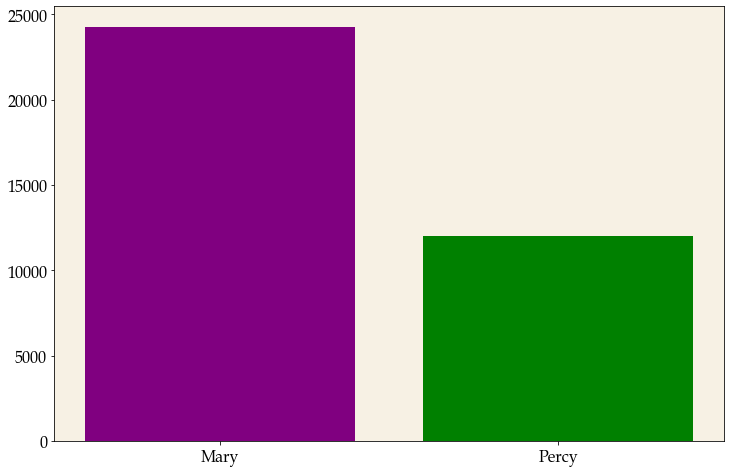

In [7]:
plt.bar(["Mary", "Percy"], [len(mary_sents), len(percy_sents)], color=["purple", "green"]);

In [8]:
random.shuffle(mary_sents)
mary_sents = mary_sents[:len(percy_sents)]

Much better!

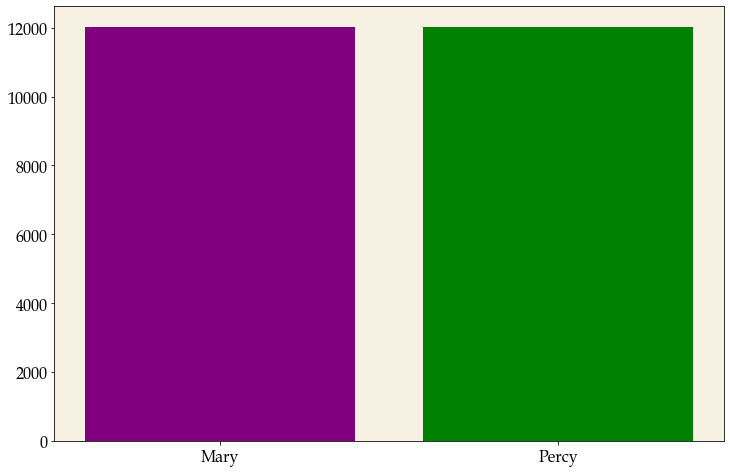

In [9]:
plt.bar(["Mary", "Percy"], [len(mary_sents), len(percy_sents)], color=["purple", "green"]);

## 4.3 Machine Learning Pipeline

### 4.3.1 Create Features and Targets

In [10]:
X = mary_sents + percy_sents
y = ["Mary"] * len(mary_sents) + ["Percy"] * len(percy_sents)

### 4.3.2 Split to Train / Test Sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.3.3 Fit the Bag-of-Words to the Training Set

In [13]:
bow = CountVectorizer()
bow.fit(X_train);

### 4.3.4 Create the Bag-of-Words Vectors

A Bag-of-Words representation of text is a vector of length equal to the number of unique words in the training set.

For example, given the two sentences: "I want to go get some ice-cream", "I wish to go get some coffee", we have 10 unique words, so each Bag-of-Words vector is of length 9, and the resulting vectors would look like this:

$$\begin{bmatrix} 1 & 1 & 1 & 1 & 1 & 1 & 1 & 0 & 0 \\ 1 & 0 & 1 & 1 & 1 & 1 & 0 & 1 & 1 \end{bmatrix}$$

In [14]:
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

### 4.3.5 Trying Different Models

As we've seen in class, the models I am trying are:
* Decision Tree
* Random Forest
* Support Vector Machine
* Multilayer Perceptron

#### Instantiate the Models

In [ ]:
decision_tree_clf = DecisionTreeClassifier()
random_forest_clf = RandomForestClassifier()
svm_clf = SVC()
mlp_clf = MLPClassifier()

#### Create Parameter Grids for Each Model

In [ ]:
decision_tree_params = {
    "max_depth": [1, 3, 5, 10, 100, None],
}

random_forest_params = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [1, 3, 5, 10, 100, None]
}

svm_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

mlp_params = {
    "hidden_layer_sizes": [(100,), (300,), (100, 100), (300, 300), (300, 100)],
    "early_stopping": [True, False]
}

#### Create a `GridSearchCV` Instance for Each Model

In [ ]:
grid_search_decision_tree = GridSearchCV(decision_tree_clf, decision_tree_params, n_jobs=-1, cv=3)
grid_search_random_forest = GridSearchCV(random_forest_clf, random_forest_params, n_jobs=-1, cv=3)
grid_search_svm = GridSearchCV(svm_clf, svm_params, n_jobs=-1, cv=3)
grid_search_mlp = GridSearchCV(mlp_clf, mlp_params, n_jobs=-1, cv=3)

#### Fit All the Models

This takes a while, as this is fitting 192 different models and picking the best one of each algorithm.

In [ ]:
for grid_search in (grid_search_decision_tree, grid_search_random_forest, grid_search_svm, grid_search_mlp):
    grid_search.fit(X_train_bow, y_train)

#### Save the Models

This took a long time, and we don't want to lose the progress.

In [ ]:
joblib.dump(grid_search_decision_tree.best_estimator_, "decision_tree.pkl")
joblib.dump(grid_search_random_forest.best_estimator_, "random_forest.pkl")
joblib.dump(grid_search_svm.best_estimator_, "svm.pkl")
joblib.dump(grid_search_mlp.best_estimator_, "mlp.pkl")

#### Load the Models

Just to check everything works.

In [15]:
dt = joblib.load("decision_tree.pkl")
rf = joblib.load("random_forest.pkl")
svm = joblib.load("svm.pkl")
mlp = joblib.load("mlp.pkl")

### 4.3.6 Evaluation

We test the accuracy of each model on the held-out test set.

In [16]:
print(f"Decision Tree: {dt.score(X_test_bow, y_test)}")
print(f"Random Forest: {rf.score(X_test_bow, y_test)}")
print(f"SVM: {svm.score(X_test_bow, y_test)}")
print(f"MLP: {mlp.score(X_test_bow, y_test)}")

Decision Tree: 0.7529118136439268
Random Forest: 0.8304908485856906
SVM: 0.8575291181364393
MLP: 0.877495840266223


### 4.3.7 Choosing a Model

The **Multilayer Perceptron** got the best score out of the four models, so I'll use it for my analysis.

In [17]:
y_pred = mlp.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Mary       0.88      0.87      0.88      2401
       Percy       0.87      0.89      0.88      2407

    accuracy                           0.88      4808
   macro avg       0.88      0.88      0.88      4808
weighted avg       0.88      0.88      0.88      4808



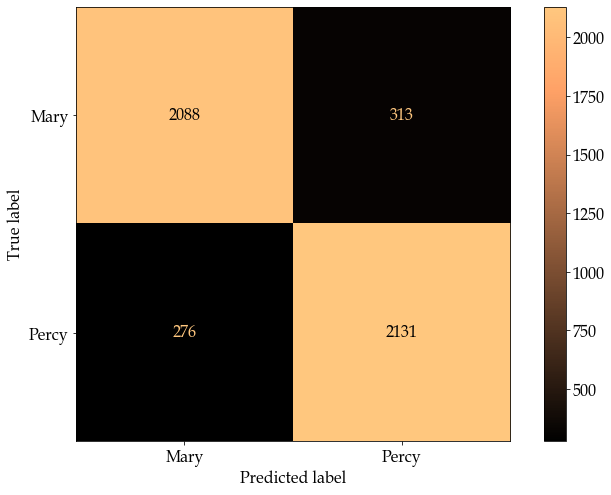

In [19]:
plot_confusion_matrix(mlp, X_test_bow, y_test, cmap="copper");

# 5. Frankenstein Analysis

First, read Frankenstein's sentences using the helper function I defined earlier:

In [20]:
frank_sents = extract_sentences(["frankenstein.txt"])

Transform the sentences into a Bag-of-Words using the same Bag-of-Words that was fit on the original training set:

In [21]:
frank_bow = bow.transform(frank_sents)

Now, I predict using the MLP model which author wrote which sentence in Frankenstein:

In [22]:
predictions = mlp.predict(frank_bow)
probabilities = mlp.predict_proba(frank_bow)

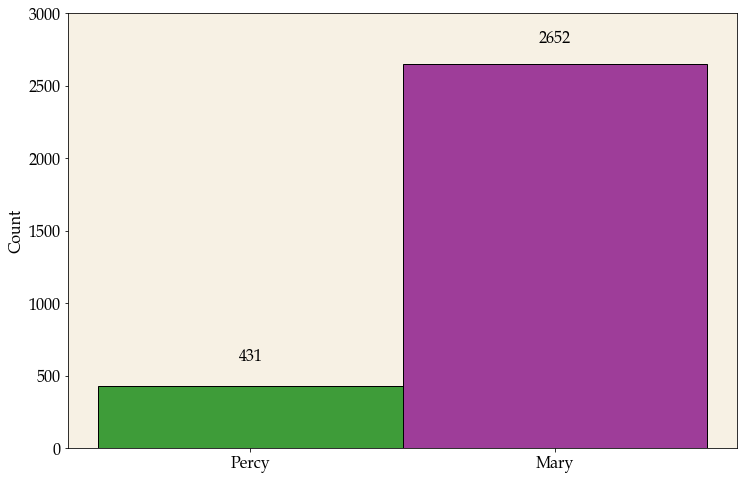

In [23]:
pred_mary = predictions[predictions == "Mary"]
pred_percy = predictions[predictions == "Percy"]
sns.histplot(pred_percy, color="green")
sns.histplot(pred_mary, color="purple")
plt.text(0, 600, str(len(pred_percy)), ha="center")
plt.text(1, 2800, str(len(pred_mary)), ha="center")
plt.ylim((0, 3000));

In my research, one of the hypotheses was that Percy Shelley wrote between 5,000 and 7,000 words in "Frankenstein". Let's see what the model thinks:

In [24]:
percy_sent_idxs, = np.where(predictions == "Percy")

In [29]:
print(f"According to the model, Percy wrote {sum([len(nltk.word_tokenize(frank_sents[idx])) for idx in percy_sent_idxs]):,} words.")

According to the model, Percy wrote 8,280 words.


Finally, let's see what is the probability that each author wrote each sentence. The closer the bar is to 1 (-1), the more the sentence is attributed to Mary (Percy).

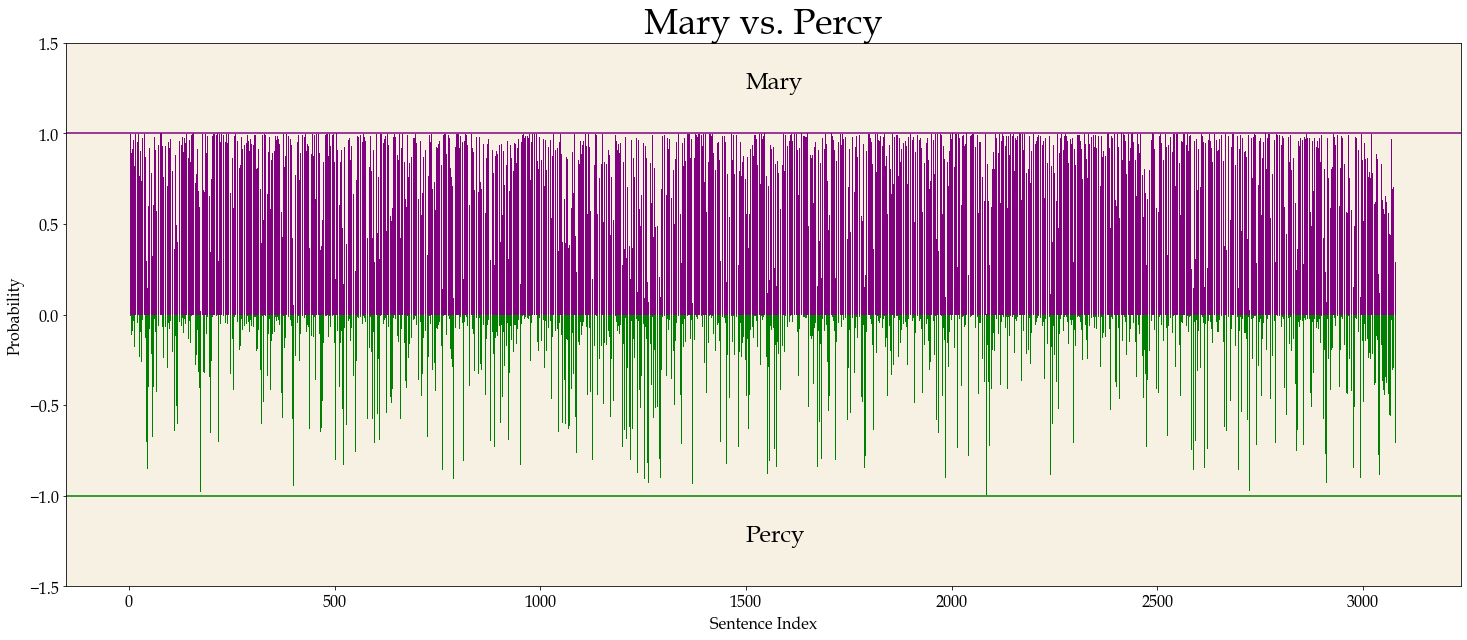

In [30]:
x = np.arange(1, len(frank_sents) + 1)
plt.figure(figsize=(25, 10))
plt.bar(x, probabilities[:, 0], color="purple")
plt.bar(x, -probabilities[:, 1], color="green")
plt.axhline(1, color="purple")
plt.axhline(-1, color="green")
plt.xlabel("Sentence Index")
plt.ylabel("Probability")
plt.ylim((-1.5, 1.5))
plt.title("Mary vs. Percy", {"fontsize": 36})
plt.text(1500, 1.25, "Mary", {"fontsize": 24})
plt.text(1500, -1.25, "Percy", {"fontsize": 24});

# 6. Conclusion

The model trained on both Mary and Percy Shelley's works does an acceptable job classifying a sentence to its corresponding author (less than 600 misclassifications out of ~4K sentences), and as such, can give us a very rough estimate of an answer to Frankenstein's authorship question: according to the model, the majority of Frankenstein was written by Mary Shelley, with Percy Shelley's "touches".

# 7. Discussion

My results are very similar to those of Charles E. Robinson's full survey (1996). Robinson used modern tools to create photofacsimiles , with them he created a new transcript. His conclusion was:

> As this edition will make evident, MWS is the creative genius by which this novel was conceived and developed, we can call PBS an able midwife who helped his wife bring her monster to life.

> PBS's contributions to Frankenstein were no more than what most publishers' editors have provided new (or old) authors or, in fact, what colleagues have provided to each other after reading each other's works in progress.

It should be noted that even though the classifier achieved 87% accuracy, this result should be taken with a grain of salt:
* The training corpus was relatively small, with only about 24K sentences in total (12K for each author).
* 87% still means that more than one sentence in ten could be misclassified, and with Frankenstein’s 3,083 tokenized sentences, this can add up to more than 300 misclassified sentences.

While Robinson estimated Percy Shelley have contributed around 4,000-5,000 words, my results show his contribution was as high as 8,280 words. This might indicate that further tuning is in order. 

Moreover, we must take into consideration the fact that many hands are involved in every book publication (until this very day), therefore it cannot be said that any of the texts used in this project were written solely by either or both of the Shelleys.

## A Personal Note

As I read about Mary Shelley, I found out that although she never went to school, her father (William Godwin, a political philosopher) provided her a rich and informal education. His library contained not only his works, but also her late mother's (Mary Wollstonecraft Godwin) which had a reputation of her own as a feminist philosopher and writer. 

With this background, I was somewhat confused by some of the widely accepted opinions which surrounded the Shelley's relationship. The assumption that Percy Shelley was the writer started when the novel was published anonymously, and this assumption was only strengthened when the draft found at 1974 had many notes which were automatically assumed to be Percy Shelley's. Some of the critics' conclusions were:

> In short, by means of condescension and egotism, he suppressed his wife’s distinctive vision. Worse still, Mary Shelley ‘shared Percy’s opinion of her inferior literary abilities’ and ‘substituted Percy’s style for her own’. It proved their marriage was one ‘in which the husband played the dominant role’ — Anne K. Mellor, 1988

> Mary Shelley felt unable ‘to put \[her\]self forward unless led, cherished & supported,’ and she perceived this need for support as feminine, ‘the woman’s love of looking up and being guided’. It might be, then, that this ideology of dependent femininity rendered her unable to write her own text without her husband’s help. Moreover, collaboration forced by a more dominant writer on a less powerful and perhaps unwilling ‘partner’ is a kind of rape; if Frankenstein is the product of such a union, then it evinces a debilitating femininity. — Johanna M. Smith, 1992

After Robinson has published his work, the critics' voices has change, and I am happy to find out that after all these years not only Mary receives the honor of being recognized for her work, but also Percy is looked upon as an encouraging husband who takes interest in his wife's work. 

> Those who knew Shelley testify to ‘quite different qualities: directness, precision, irony, command, qualities frequently found in the early journal entries’. Indeed, in Mary’s own self-assessments, Leader finds evidence of her ‘belief in herself as an author’. It is more likely that, when writing Frankenstein, she ‘consciously, willingly welcomed Percy Shelley’s contributions’. — Zachary Leader, 1996

> Percy’s attitude towards his wife’s writing was positive. He encouraged her to translate Alfieri’s Mirra, ‘supplied lyrics for her mythological dramas Proserpine and Midas (1820)’, and welcomed her contributions to his translation of Spinoza’s Tractatus Theologico-Politicus. — Nora Crook, 2013

> As the years have passed, the idea that husband and wife worked alongside each other in ways that did not entail bullying, harassment, or physical violence has begun to find acceptance. — Robinson, 1996

> I personally prefer to give both of them the benefit of the doubt and conjecture that (1) PBS suggested and made alterations to the text of Frankenstein for the purpose of improving an already excellent narrative (in \[?February 1818\] he wrote a review that judged the published novel “one of the most original and complete productions of the day”) and that (2) MWS accepted the suggestions and alterations that she agreed with. — Robinson, 1996

# External Links and Sources

* Duncan Wu (2015). 30 Great Myths about the Romantics. WIley-Blackwell. p. 214. ISBN 978-1118843260.
* [Shelley-Godwin Archive website](http://shelleygodwinarchive.org/contents/frankenstein/the-frankenstein-notebooks-introduction)
* [Works by Mary Wollstonecraft Shelley at Project Gutenberg](http://www.gutenberg.org/ebooks/author/61)
* [Works by Percy Bysshe Shelley at Project Gutenberg](https://www.gutenberg.org/ebooks/author/1529)
* [The Frankenstein authorship question at Wikipedia](https://en.wikipedia.org/wiki/Frankenstein_authorship_question)
* [Villa Diodati at Wikipedia](https://en.wikipedia.org/wiki/Villa_Diodati)
* מנהיים, נועה. הרשת התרבותית. הוצאת גרף, 2019, פרק 38.
* טריאסט איילת, מנהיים נועה. 27.6.2019, פרנקנשטיין (פרק 1), פודקאסט ב-האחיות גרים, גלי צה"ל.
[https://glz.co.il/גלצ/תוכניות/האחיות-גרים/האחיות-גרים08-07-2020-2031](https://bit.ly/3ufBJcr)
